In [1]:
import os

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns

from collab.foraging import locust as lc
from collab.utils import find_repo_root

In [2]:
locds = lc.LocustDS(
    data_code="15EQ20191202",
    start=0,
    end=10,
)

locds.run_inference(
    "length",
    num_iterations=1500,
    num_samples=150,
    lr=0.001,
)

Loading inference samples


tensor(0.4823, dtype=torch.float64)


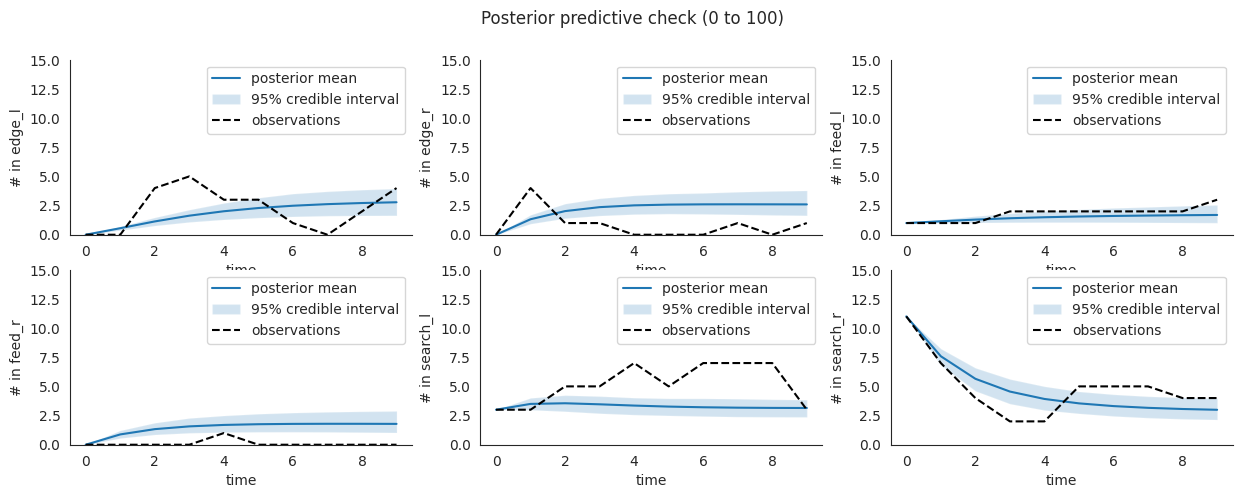

In [3]:
# validation data at this point are more even, easier to guess
locds.posterior_check()
locds.evaluate()
print(locds.rsquared)

Loading validation samples
tensor(0.3560, dtype=torch.float64)


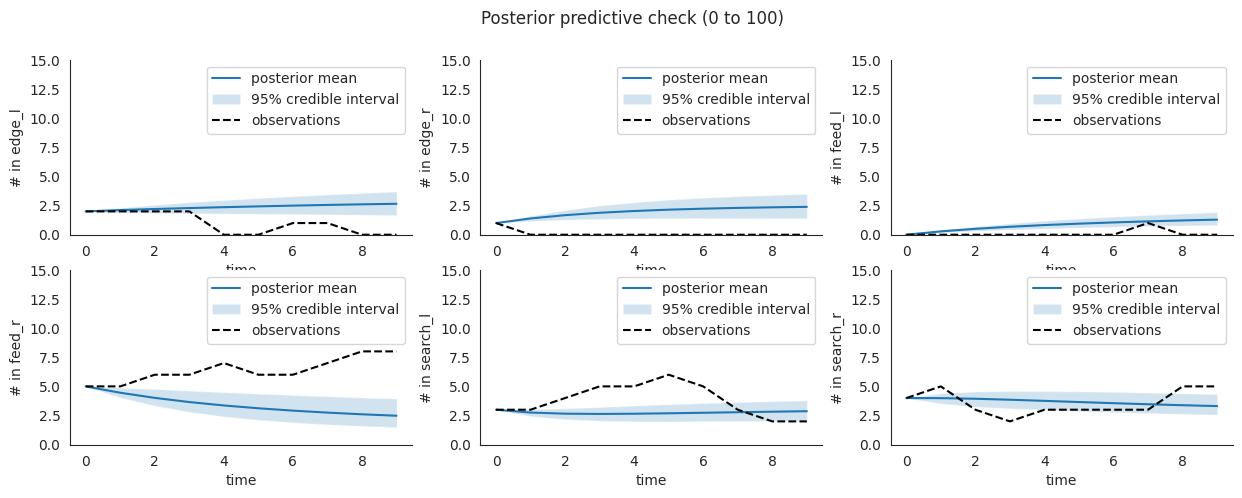

In [4]:
locds.validate(validation_data_code="15EQ20191205")
print(locds.validation["15EQ20191205"]["rsquared"])
locds.posterior_check(samples=locds.v_samples, subset=locds.v_subset)

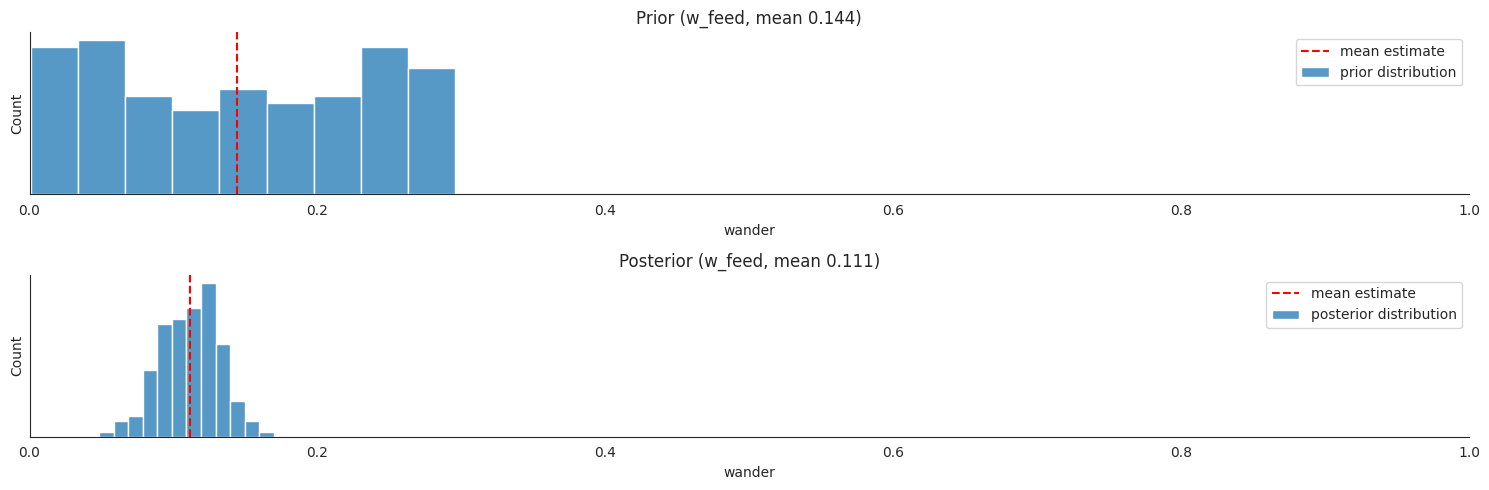

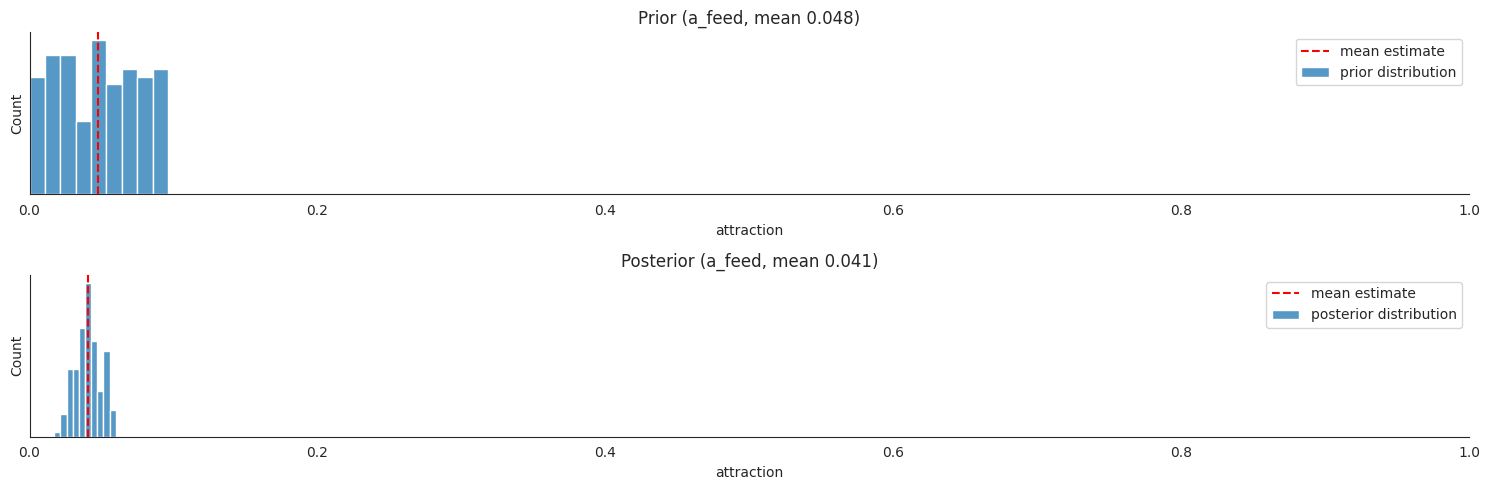

In [5]:
locds.get_prior_samples(num_samples=150)
locds.plot_param_estimates(3, 4)

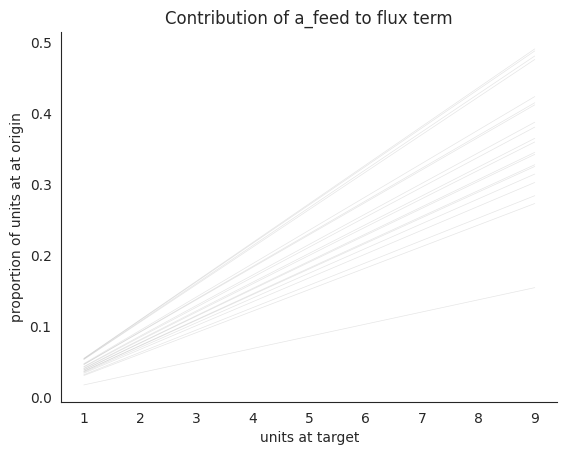

In [6]:
lc.plot_ds_interaction(locds.samples, "attraction", 4, xlim=10, num_lines=20)

0
Loading inference samples
30
Loading inference samples
60
Running inference
Running SVI for 1500 steps...
[iteration 0001] loss: 91.5669
[iteration 0100] loss: 96.8145
[iteration 0200] loss: 99.0704
[iteration 0300] loss: 95.1113
[iteration 0400] loss: 88.9598
[iteration 0500] loss: 89.7459
[iteration 0600] loss: 89.4216
[iteration 0700] loss: 98.0727
[iteration 0800] loss: 90.6675
[iteration 0900] loss: 88.1622
[iteration 1000] loss: 84.1641
[iteration 1100] loss: 87.6946
[iteration 1200] loss: 79.2620
[iteration 1300] loss: 84.9476
[iteration 1400] loss: 88.1695
[iteration 1500] loss: 86.8862


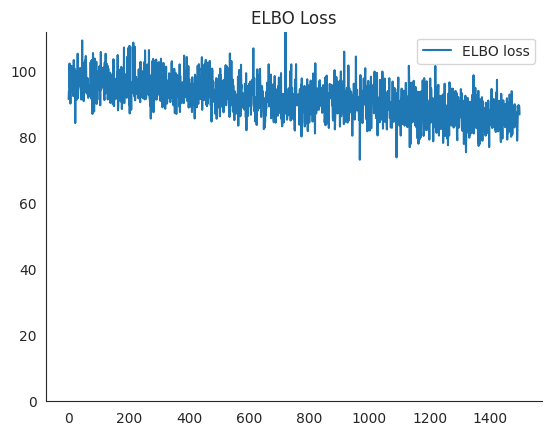

90
Running inference
Running SVI for 1500 steps...
[iteration 0001] loss: 91.0901
[iteration 0100] loss: 88.0207
[iteration 0200] loss: 99.5917
[iteration 0300] loss: 91.2869
[iteration 0400] loss: 94.2479
[iteration 0500] loss: 85.3735
[iteration 0600] loss: 93.4132
[iteration 0700] loss: 86.8808
[iteration 0800] loss: 88.6785
[iteration 0900] loss: 86.4914
[iteration 1000] loss: 83.3236
[iteration 1100] loss: 75.1102
[iteration 1200] loss: 81.4937
[iteration 1300] loss: 89.3515
[iteration 1400] loss: 84.3150
[iteration 1500] loss: 91.3109


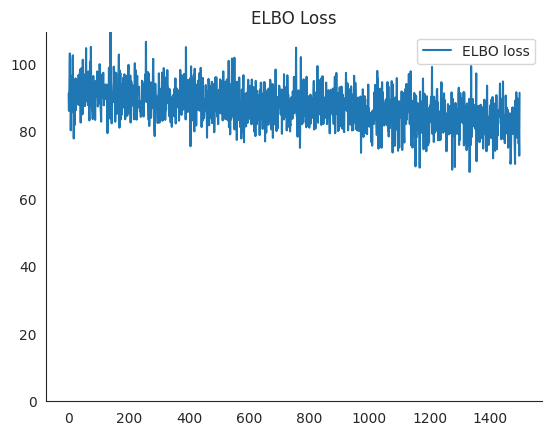

120
Running inference
Running SVI for 1500 steps...
[iteration 0001] loss: 102.1871
[iteration 0100] loss: 96.4058
[iteration 0200] loss: 88.5181
[iteration 0300] loss: 95.9389
[iteration 0400] loss: 87.6843
[iteration 0500] loss: 83.2668
[iteration 0600] loss: 90.5706
[iteration 0700] loss: 84.6405
[iteration 0800] loss: 85.1076
[iteration 0900] loss: 87.9056
[iteration 1000] loss: 92.3301
[iteration 1100] loss: 87.6547
[iteration 1200] loss: 91.7349
[iteration 1300] loss: 80.7545
[iteration 1400] loss: 87.7706
[iteration 1500] loss: 81.3507


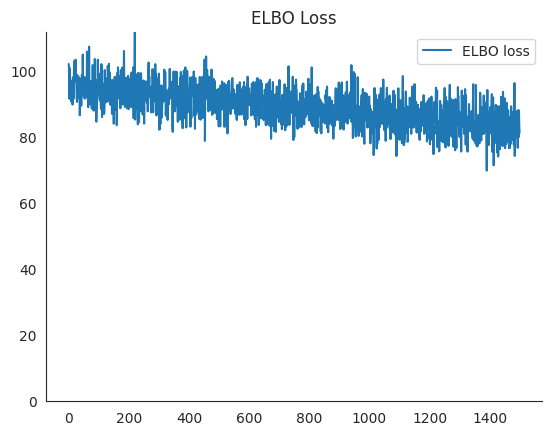

150
Running inference
Running SVI for 1500 steps...
[iteration 0001] loss: 97.0848
[iteration 0100] loss: 99.1688
[iteration 0200] loss: 99.0241
[iteration 0300] loss: 103.4205
[iteration 0400] loss: 94.0308
[iteration 0500] loss: 98.0707
[iteration 0600] loss: 88.2773
[iteration 0700] loss: 91.2761
[iteration 0800] loss: 87.6801
[iteration 0900] loss: 92.2868
[iteration 1000] loss: 91.4276
[iteration 1100] loss: 91.3804
[iteration 1200] loss: 90.8691
[iteration 1300] loss: 94.5285
[iteration 1400] loss: 106.1229
[iteration 1500] loss: 83.0443


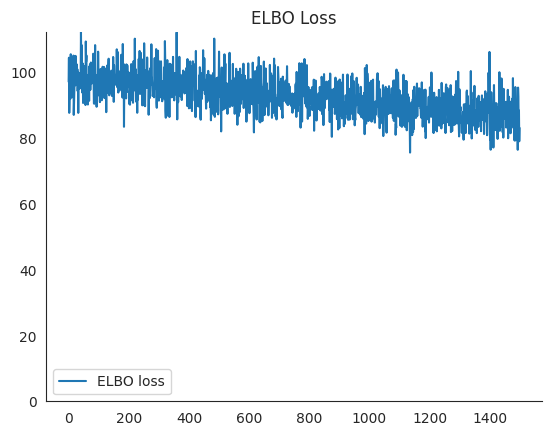

In [10]:
data_code = "15EQ20191202"

samples_a_feed_10 = []

root = find_repo_root()
data_path = os.path.join(root, f"data/foraging/locust/ds/locust_samples_a_feed_10.pkl")

if os.path.exists(data_path):
    with open(data_path, "rb") as f:
        samples_a_feed_10 = dill.load(f)
else:
    for start in [0, 30, 60, 90, 120, 150]:
        print(start)
        locds = lc.LocustDS(
            data_code=data_code,
            start=start,
            end=start + 10,
        )

        locds.run_inference("length", num_iterations=1500, num_samples=150, lr=0.001)
        samples_a_feed_10.append(locds.samples["attraction"][:, 4])

    with open(data_path, "wb") as f:
        dill.dump(samples_a_feed_10, f)

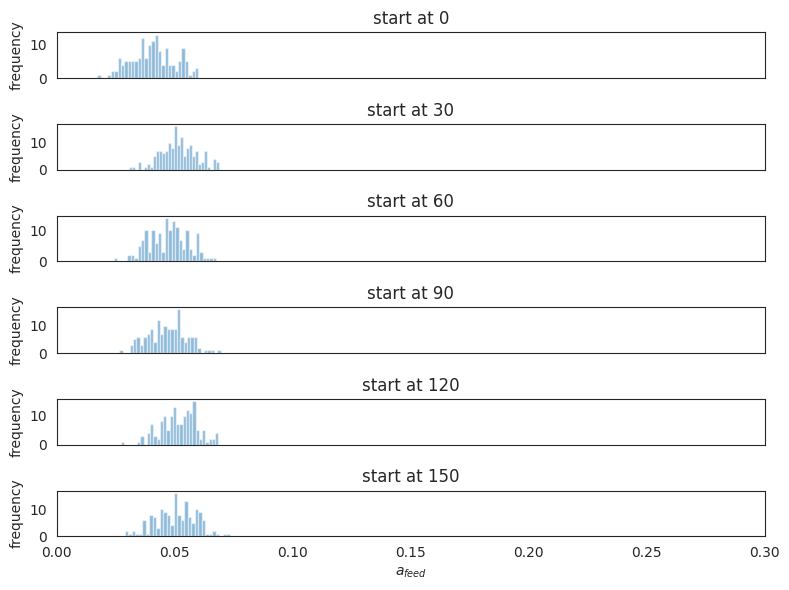

In [14]:
start = [0, 30, 60, 90, 120, 150]

fig, axs = plt.subplots(len(start), 1, figsize=(8, 6), sharex=True)

for i, (s, tensor) in enumerate(zip(start, samples_a_feed_10)):
    axs[i].hist(tensor, bins=30, alpha=0.5, label=f"start at {s}")
    axs[i].set_ylabel("frequency")
    axs[i].title.set_text(f"start at {s}")
    axs[i].set_xlim(0, 0.3)

axs[-1].set_xlabel("$a_{feed}$")
plt.tight_layout()
plt.show()